In [1]:
# module import

import matplotlib.pyplot as plt
from scipy.stats import linregress
import numpy as np
from matplotlib.lines import Line2D
import math

In [83]:
# set your trajectory here

nsolv=2000
rvalue=0.4
dielectric=0.2
run = 1

# Set temperature of system, charge of ion, sigma value (from lammps input file)
# Do not touch below
base_path = f"/Users/kimdaehyeok/Desktop/Kimgroup/Project/GCMD/data/dielectric_{dielectric}/solv_{nsolv}/r-{rvalue}/"
temperature = 1.0
cation_charge = 1
anion_charge = -1
sigma = 1
num_ion = rvalue*nsolv

# Calculate Debye Screening Length

In [84]:
def parse_lammps_trajectory(file_path):
    """
    Parse a LAMMPS trajectory file to extract the number of atoms (N)
    and box volumes (V) for all timesteps.

    Parameters:
        file_path (str): Path to the LAMMPS trajectory file.

    Returns:
        tuple: (Number of atoms, list of box volumes, average box volume)
    """
    num_atoms = None
    box_volumes = []

    with open(file_path, "r") as file:
        while True:
            line = file.readline()
            if not line:
                break  # 파일 끝까지 읽으면 종료

            if "ITEM: NUMBER OF ATOMS" in line:
                num_atoms = int(file.readline().strip())

            elif "ITEM: BOX BOUNDS" in line:
                box_bounds = []
                for _ in range(3):  # x, y, z 방향의 경계값 읽기
                    bounds = list(map(float, file.readline().strip().split()))
                    box_bounds.append(bounds)

                # 부피 계산
                volume = 1.0
                for bounds in box_bounds:
                    volume *= bounds[1] - bounds[0]

                box_volumes.append(volume)

    if num_atoms is None or not box_volumes:
        raise ValueError("Invalid trajectory file format or missing data.")

    volume = np.mean(box_volumes)

    return num_atoms, volume , box_bounds

def calculate_debye_length_lj(
    num_cations, num_anions, volume, z_cation, z_anion, temperature, sigma
):
    """
    Calculate Debye screening length in LJ units and convert to angstrom.

    Parameters:
        num_cations (int): Number of cations.
        num_anions (int): Number of anions.
        volume (float): Simulation box volume (in LJ units).
        z_cation (float): Charge of cations (absolute value) in LJ units.
        z_anion (float): Charge of anions (absolute value) in LJ units.
        temperature (float): System temperature (in LJ units, typically 1 in LJ units).
        sigma (float): The sigma parameter (in angstroms, for conversion).

    Returns:
        float: Debye screening length in angstroms.
    """
    # Constants for LJ units
    k_B = 1  # Boltzmann constant in LJ units
    e = 1  # Elementary charge in LJ units (system dependent)

    # Number densities for each ion type in LJ units
    n_cation = num_cations / volume  # Cation number density (LJ units)
    n_anion = num_anions / volume  # Anion number density (LJ units)

    # Sum over n_i * z_i^2 for all ion types
    ion_sum = n_cation * z_cation**2 + n_anion * z_anion**2

    # Calculate Debye length in LJ units
    debye_length_lj = math.sqrt(dielectric / ((ion_sum)*8*np.pi))  # LJ units

    # Convert to angstroms by multiplying with sigma
    debye_length_angstrom = debye_length_lj * sigma

    return n_cation, n_anion, debye_length_angstrom


In [85]:
# Example usage
file_path = []
debyelength=[]
for i in range (1,run+1):
    temp_path = base_path+f"run{i}/spm_lj.lammpstrj"
    file_path.append(temp_path)

for trj_path in file_path:

    try:
        num_atoms, volume, box_bounds = parse_lammps_trajectory(trj_path)
        print(f"Number of Atoms (N): {num_atoms}")
        print(f"Box Volume (V): {volume:.2f}")
        print(f"Box Bounds: {box_bounds}")
    except Exception as e:
        print(f"Error: {e}")

    print(volume)
    n_cation, n_anion, debye_length = calculate_debye_length_lj(
        num_ion, num_ion, volume, cation_charge, anion_charge, temperature, sigma
    )

    debyelength.append(debye_length)

print(debyelength)
avg_ld=np.average(debyelength)
print(f"Average Debye Screening Length: {avg_ld:.6e} (Å)")
#print(f"Cation Number Density: {n_cation:.2e} (LJ units)")
#print(f"Anion Number Density: {n_anion:.2e} (LJ units)")
#print(f"Debye Screening Length: {debye_length:.2e} (Å)")

Number of Atoms (N): 3600
Box Volume (V): 4681.65
Box Bounds: [[-8.355273564481903, 8.355273564481903], [-8.355273564481903, 8.355273564481903], [-8.355273564481903, 8.355273564481903]]
4681.64832326354
[0.15259295040905355]
Average Debye Screening Length: 1.525930e-01 (Å)


# g_(r) & |r*g_zz(r)| plotting

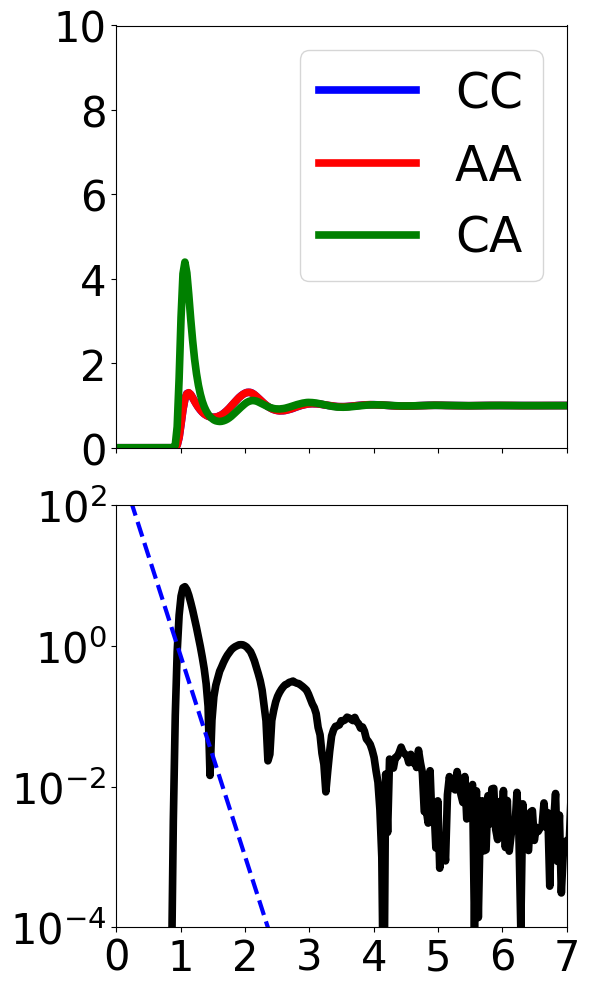

In [88]:
def read_data_from_files(file_paths):
    x = None
    y_values = []

    # Read data from multiple files
    for file_path in file_paths:
        with open(file_path, 'r') as file:
            lines = file.readlines()[1:]  # 첫 번째 라인을 건너뛰는 경우
            if x is None:
                x = [float(line.split()[0]) for line in lines]
            y_values.append([float(line.split()[1]) for line in lines])

    # numpy 배열로 변환
    y_values = np.array(y_values)

    # 평균 및 표준오차(표준편차/sqrt(N)) 계산
    y_avg = np.mean(y_values, axis=0)
    y_std = np.std(y_values, axis=0, ddof=1)  # sample standard deviation
    y_se = y_std / np.sqrt(y_values.shape[0]) # 표준오차

    return x, y_avg, y_se

def generate_file_paths(n):
    cc_files = [
        f"{base_path}gCC_run{n}.dat",
        f"{base_path}gCC_run{n}.dat",
        f"{base_path}gCC_run{n}.dat",
        f"{base_path}gCC_run{n}.dat",
        f"{base_path}gCC_run{n}.dat",
        f"{base_path}gCC_run{n}.dat",
        f"{base_path}gCC_run{n}.dat",
        f"{base_path}gCC_run{n}.dat",
        f"{base_path}gCC_run{n}.dat",
        f"{base_path}gCC_run{n}.dat",
    ]
    
    aa_files = [
        f"{base_path}gAA_run{n}.dat",
        f"{base_path}gAA_run{n}.dat",
        f"{base_path}gAA_run{n}.dat",
        f"{base_path}gAA_run{n}.dat",
        f"{base_path}gAA_run{n}.dat",
        f"{base_path}gAA_run{n}.dat",
        f"{base_path}gAA_run{n}.dat",
        f"{base_path}gAA_run{n}.dat",
        f"{base_path}gAA_run{n}.dat",
        f"{base_path}gAA_run{n}.dat",
    ]
    
    ca_files = [
        f"{base_path}gCA_run{n}.dat",
        f"{base_path}gCA_run{n}.dat",
        f"{base_path}gCA_run{n}.dat",
        f"{base_path}gCA_run{n}.dat",
        f"{base_path}gCA_run{n}.dat",
        f"{base_path}gCA_run{n}.dat",
        f"{base_path}gCA_run{n}.dat",
        f"{base_path}gCA_run{n}.dat",
        f"{base_path}gCA_run{n}.dat",
        f"{base_path}gCA_run{n}.dat",
    ]

    zz_files = [
        f"{base_path}gZZ_run{n}.dat",
        f"{base_path}gZZ_run{n}.dat",
        f"{base_path}gZZ_run{n}.dat",
        f"{base_path}gZZ_run{n}.dat",
        f"{base_path}gZZ_run{n}.dat",
        f"{base_path}gZZ_run{n}.dat",
        f"{base_path}gZZ_run{n}.dat",
        f"{base_path}gZZ_run{n}.dat",
        f"{base_path}gZZ_run{n}.dat",
        f"{base_path}gZZ_run{n}.dat",
    ]
    
    return cc_files, aa_files, ca_files, zz_files


# 파일 경로 생성
cc_files, aa_files, ca_files, zz_files = generate_file_paths(run)

# 데이터 읽기 및 평균/표준오차 계산
x1, y1_avg, y1_se = read_data_from_files(cc_files)
x2, y2_avg, y2_se = read_data_from_files(aa_files)
x3, y3_avg, y3_se = read_data_from_files(ca_files)
x4, y4_avg, y4_se = read_data_from_files(zz_files)

# 필요 시 x값 스케일 조정 (여기서는 곱하기 1이므로 변화 없음)
x1 = [value * 1 for value in x1]
x2 = [value * 1 for value in x2]
x3 = [value * 1 for value in x3]
x4 = [value * 1 for value in x4]

# 그래프 설정

# 에러바를 포함하여 그래프 그리기
#plt.errorbar(x1, y1_avg, yerr=y1_se, label='CC', linestyle='-', color='blue', capsize=3)
#plt.errorbar(x2, y2_avg, yerr=y2_se, label='AA', linestyle='-', color='red', capsize=3)
#plt.errorbar(x3, y3_avg, yerr=y3_se, label='CA', linestyle='-', color='green', capsize=3)

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(6, 10), sharex=True)

#g(r) 설정
axes[0].plot(x1, y1_avg, label='CC', linestyle='-', color='blue', linewidth=5.5)
axes[0].plot(x2, y2_avg, label='AA', linestyle='-', color='red', linewidth=5.5)
axes[0].plot(x3, y3_avg, label='CA', linestyle='-', color='green', linewidth=5.5)
axes[0].legend(fontsize=35)
axes[0].set_ylim(0, 10)
axes[0].set_xlim(0,7)

#|r*g_zz(r)| 설정
axes[1].plot(x4, np.abs(x3*y4_avg), linestyle='-', color='black', linewidth=5.5)
axes[1].plot(x4, np.exp(-1 / avg_ld * np.array(x4))*500, color="blue",linestyle="--", linewidth=3)
axes[1].set_yscale("log")
axes[1].set_ylim(0.0001, 100)
axes[1].set_xlim(0,7)
axes[1].set_xticks([0,1,2,3,4,5,6,7])


for ax in axes:
    ax.tick_params(axis="both", labelsize=30)
    #ax.yaxis.set_visible(False)

# 그래프 표시
plt.tight_layout()
plt.show()
